In [28]:
from Model import Model
import pandas as pd
import numpy as np
import itertools
import math
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

shap.initjs()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
model_rf = Model('ranf',_type='class')

In [30]:
X,Y = model_rf.preprocessing.load_data('../../Frame_Analysis/Microsoft Ad Optimization-AI Data_Survey Aggregated Data 13062019.xlsx',labels=False,sheet_name="Sheet2")
X = X[X['Country']== 'US']
X= X.reset_index()
Y = X[['Interest Trace']]

In [31]:
features = ['length_of_ad_15','ad_type_tv','Age','Gender','Emotion','Ethnicity',
            'Microsoft-Logo','Intel_Logo','Sub-Brands','Other-text',
            'Object 1-Laptop','object 2- Tablet','object 3-Mobile','object 4-PC']

In [32]:
class_dict ={}
le = LabelEncoder()

In [33]:
X_new = pd.DataFrame()
X_new['Video Name'] = X['Video Name']
# X_new = X_new.set_index(X['Video Name'])

In [34]:
X['Ocr'] = X['Image Name'].apply(lambda x:float(x.split('_')[-1].replace('.jpg','')))

In [35]:
X_new['Ocr'] = X['Ocr']

In [36]:
X_new['Length_of_ad'] = X['Length of the Ad']

In [37]:
def dur_division(x):
#     print(1,x)
    for i in range(0,10):
        if x['Ocr']/x['Length_of_ad'] <= (i+1)*0.1 and x['Ocr']/x['Length_of_ad'] >= (i)*0.1:
            x['Ocr'] = i
    if x['Ocr']/x['Length_of_ad'] >= 1:
        x['Ocr'] = 9
    return x

In [38]:
X_new = X_new.apply(dur_division,axis=1)
X_new = X_new.drop('Length_of_ad',1)

In [39]:
useful_columns = ['Microsoft_Logo','Microsoft_Windows_Brand','Microsoft_Windows10_Brand', 'Microsoft_SurfacePro4_Brand',
'Microsoft_SurfaceBook_Brand', 'Microsoft_SurfacePen_Brand']

for col in useful_columns:
    X.loc[X[col].isna(),col] = 0
    X.loc[X[col]=='-',col] = 0

In [40]:
arr = ["Laptop","Tablet","Mobile","PC"]
for i,c in enumerate(['Object 1-Laptop','object 2- Tablet','object 3-Mobile','object 4-PC']):
    X.loc[X[c]=="Yes",c] = arr[i]
    X.loc[X[c]=="yes",c] = arr[i]
    X.loc[X[c]=="No",c] = float('nan')
    X.loc[X[c]==" ",c] = float('nan')

In [41]:
X_new['length_of_ad_30'] = le.fit_transform(X['Length of the Ad'])
class_dict['length_of_ad_30'] = le.classes_
X_new['ad_type_tv'] = le.fit_transform(X['AD Type: TV/DIGITAL'])
class_dict['ad_type_tv'] = le.classes_

In [42]:
def separate(x,i):
    if x == 'No Face Found':
        return "nan"
    else:
        return np.array(x.replace('[','').replace(']','').replace("'",'').split(','))[i]

In [43]:
X['Age'] = X['Age-Gender'].apply(lambda x: separate(x,0))
X['Gender'] = X['Age-Gender'].apply(lambda x: separate(x,1))
for col in useful_columns:
    X_new[col.lower()] = X[col]
    X_new[col.lower()] = X_new[col.lower()].astype('float32')

In [44]:
ohe = OneHotEncoder()

In [45]:
data = ohe.fit_transform(np.reshape(X_new['Ocr'].values,(-1,1))).toarray()
class_ = ['frame_0_10','frame_10_20','frame_20_30','frame_30_40','frame_40_50','frame_50_60','frame_60_70','frame_70_80','frame_80_90','frame_90_100']
for c in ohe.categories_[0]:
    X_new[class_[int(c)]] = data[:,int(c)]
X_new = X_new.drop('Ocr',1)

In [46]:
for col in features[2:]:
    X[col] = X[col].apply(lambda x: "nan" if isinstance(x,type(float('nan'))) else x.lower())
    data = ohe.fit_transform(np.reshape(X[col].values,(-1,1))).toarray()  
    for i,unique_col in enumerate(ohe.categories_[0]):
        if unique_col != 'nan' and unique_col !='no face found' :
            X_new[unique_col] = data[:,i]
#     class_dict[col] = le.classes_

In [47]:
# new_features =[["happiness",' female'],["surprise"," male"],["neutral"," male"],["happiness","age: 0-5"],["disgust","age: 45-60"],["surprise","age: 0-5"],["neutral","age: 25-34"],["happiness","eastasian"],["surprise","eastasian"]]
# age_cols = ['age: 0-15', 'age: 0-5', 'age: 15-24','age: 25-34', 'age: 35-44', 'age: 45-60']
# ethinicity_cols = ['african', 'caucasian', 'eastasian','latino']
# age_ethinicity_col = list(itertools.product(age_cols,ethinicity_cols))
# new_features.extend(age_ethinicity_col)
# for f1,f2 in new_features:
#     X_new[f1+'_'+f2] = X[f1]+X[f2]
#     X_new[X_new[f1+'_'+f2] == 1] = 0
#     X_new[X_new[f1+'_'+f2] == 2] = 1
# X_new['Happiness_length_of_ad_impact'] = X_new['Happiness_dur'] * (1-X_new['length_of_ad_15'])

In [48]:
def transform_y(x,y_max,n):
    per = 1/n
    for i in range(0,n):
        if x['Interest Trace']/y_max <= (i+1)*(per) and x['Interest Trace']/y_max >= (i)*per:
            x['Interest Trace'] = i
    return x

In [49]:
Y_1=Y.apply(lambda x:transform_y(x,Y.max()['Interest Trace'],4),1)

In [50]:
# X_new[[useful_columns]] = X_new[[useful_columns]].astype('float32')
X_train,X_test,y_train,y_test = train_test_split(X_new,Y_1,test_size=0.3,random_state=123)

In [51]:
print("------------------------ RF Model Training ----------------------------\n")
trained_rf = model_rf.train(X_train,y_train,X_test,y_test,metrics='accuracy',set_params=True,params={'Interest Trace':{'bootstrap': False, 'max_depth': 25, 'max_features': 0.3, 'min_samples_leaf': 2, 'n_estimators': 300}},plot_error=False)

------------------------ RF Model Training ----------------------------

Interest Trace


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


For training set
accuracy_score: 0.699543
For test set
accuracy_score: 0.712500




[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [52]:
model_xgb = Model('xgb','class')
print("------------------------ XGB Model Training ----------------------------\n")
trained_xgb = model_xgb.train(X_train,y_train,X_test,y_test,metrics='accuracy',set_params=True,params={'Interest Trace':{'colsample_bytree': 0.4, 'max_depth': 15, 'min_samples_leaf': 4, 'n_estimators': 1000,"objective":'reg:linear',"silent":False,"alpha":1,"learning_rate":0.01,"reg_lambda":1}},plot_error=False)

------------------------ XGB Model Training ----------------------------

Interest Trace


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   53.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


For training set
accuracy_score: 0.704101
For test set
accuracy_score: 0.720625




In [49]:
model_dt = Model('DT','class')
print("------------------------ DT Model Training ----------------------------\n")
trained_dt = model_dt.train(X_train,y_train,X_test,y_test,metrics='accuracy',set_params=True,params={'Interest Trace':{'criterion':'gini','max_depth': 6, 'max_features': 0.9, 'min_samples_leaf': 2,"presort":True,'max_leaf_nodes':10}},plot_error=False)

------------------------ DT Model Training ----------------------------

Interest Trace
For training set
accuracy_score: 0.664713
For test set
accuracy_score: 0.671875




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [27]:
model_dt.plot_tree(class_names=['0_10','25_50','50_75','75_100'],savefig=True)

In [61]:
cnt=0
for i in y_test.index.values:
    print("True value:",y_test.loc[i].values,"Prediction:",trained_dt[0].predict(X_23.loc[[i]]))
    if(y_test.loc[i].values == trained_dt[0].predict(X_23.loc[[i]])):
        cnt+=1

True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [2.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [0.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [0.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [0.]
True value: [2.] Prediction: [2.]
True value: [0

True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [0.] Prediction: [2.]
True value: [0.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [3.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [1

True value: [2.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [0.] Prediction: [0.]
True value: [3.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [0.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [1.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [2.] Prediction: [3.]
True value: [3

True value: [3.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [0.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [0.]
True value: [1.] Prediction: [1.]
True value: [0.] Prediction: [0.]
True value: [2.] Prediction: [1.]
True value: [3.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [0.] Prediction: [1.]
True value: [0

True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [0.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [3.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [1

True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [3.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [0.] Prediction: [0.]
True value: [3.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [1.]
True value: [3.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [0.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [0.]
True value: [3.] Prediction: [2.]
True value: [2

True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [0.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [2.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [0.] Prediction: [0.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [2.] Prediction: [2.]
True value: [1.] Prediction: [1.]
True value: [1.] Prediction: [2.]
True value: [1.] Prediction: [2.]
True value: [2.] Prediction: [2.]
True value: [3.] Prediction: [2.]
True value: [2

In [28]:
rfe = RFE(trained_dt[0],n_features_to_select=10,step=5,verbose=1)
rfe = rfe.fit(X_train.drop('Video Name',1),y_train)

Fitting estimator with 81 features.
Fitting estimator with 76 features.
Fitting estimator with 71 features.
Fitting estimator with 66 features.
Fitting estimator with 61 features.
Fitting estimator with 56 features.
Fitting estimator with 51 features.
Fitting estimator with 46 features.
Fitting estimator with 41 features.
Fitting estimator with 36 features.
Fitting estimator with 31 features.
Fitting estimator with 26 features.
Fitting estimator with 21 features.
Fitting estimator with 16 features.
Fitting estimator with 11 features.


In [29]:
X_train.drop('Video Name',1).columns.values[rfe.support_]

array(['length_of_ad_30', 'microsoft_logo', 'frame_0_10', 'frame_10_20',
       'frame_20_30', 'frame_30_40', 'frame_90_100', 'african',
       'microsoft', 'laptop'], dtype=object)

In [58]:
rfe.ranking_

array([ 1,  4,  1,  7,  6,  4,  7, 10,  1,  1,  1,  3,  4,  1,  1,  1,  2,
        4, 12,  6,  4,  3,  6,  7,  5,  3,  9, 15, 15,  8,  3,  8,  9,  5,
        6,  1,  8,  3, 16, 16, 16, 16, 10, 15, 16, 14,  9, 14, 15, 14,  7,
        6,  7, 14, 10,  9, 11, 12, 11, 11, 11, 14, 10, 10, 13, 13,  8, 13,
       11, 12, 13, 12,  9, 12,  5,  5,  8,  1,  5, 13, 15])

Interest Trace
Feature ranking:
frame_0_10
frame_10_20
length_of_ad_30
microsoft_logo
frame_70_80
frame_60_70
laptop
frame_20_30
frame_50_60
frame_90_100
frame_80_90
microsoft
frame_30_40
frame_40_50
neutral
tablet
ad_type_tv
 male
microsoft_surfacepro4_brand
eastasian
age: 25-34
caucasian
 female
happiness
african
age: 35-44
age: 15-24
dell xps
hp
surface go
microsoft_windows10_brand
age: 45-60
surface pro 6
age: 0-5
microsoft_surfacebook_brand
surface laptop
microsoft_windows_brand
windows 10
windows 10 pcs
surprise
surface book
sadness
surface pro 4
hp spectre x360, windows
latino
the new surface pro
hp spectre x360
macbook air
lenovo
lenovo yoga 910
surface pro 4, apple_macbookair13
microsoft surface
lenovo yoga 720
pc
surface pro 4, hp spectre x360
windows 10, hp_spectre
disgust
asus
surface pro 4, macbook air
asus t102
microsoft_surfacepen_brand
surface pro 4, macbook air13, macbook air
dell pcs
surface pen
angry
surface pro
mobile
windows
macbook pro
dell
windows 10, windows
age

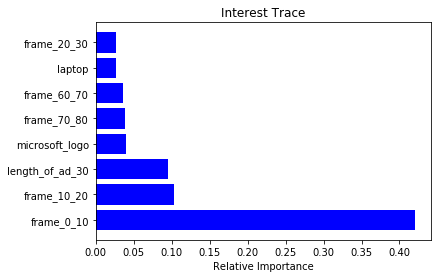

In [29]:
model_rf.plot_feature_importance(trained_rf,10,y_test.columns,X_test.columns[1:])

Interest Trace
frame_0_10
frame_10_20
frame_60_70
frame_70_80
length_of_ad_30
frame_50_60
frame_80_90
frame_90_100
frame_40_50
dell xps
frame_20_30
surface pro 6
laptop
surface go
tablet
microsoft
hp spectre x360, windows
the new surface pro
frame_30_40
ad_type_tv
windows 10 pcs
microsoft surface
age: 45-60
surface pro 4, apple_macbookair13
hp
lenovo yoga 720
suface laptop
surface book
microsoft_logo
surface laptop
caucasian
microsoft_windows_brand
macbook air
windows 10, windows
neutral
microsoft_surfacepen_brand
lenovo
eastasian
surface pro
age: 0-5
age: 35-44
 female
surface pro 4
age: 15-24
african
happiness
 male
surface pen
age: 25-34
windows 10, hp_spectre
windows 10
windows
microsoft_surfacebook_brand
hp spectre x360
lenovo yoga 910
microsoft_surfacepro4_brand
surface pro 4, hp spectre x360
dell pcs
latino
surface pro 4, macbook air13, macbook air
surprise
asus t102
asus
sadness
pc
the surface laptop
microsoft_windows10_brand
fear
mobile
dell
surface pro 4, macbook air
angry
de

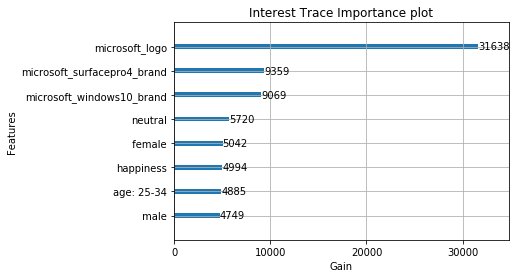

In [30]:
model_xgb.plot_feature_importance(trained_xgb,10,y_test.columns,X_test.columns[1:])

In [37]:
from sklearn.model_selection import GridSearchCV
parameters_tree={"colsample_bytree":[0.4,0.6],"max_depth":[6,8,13,15,20,50,100],"min_samples_leaf":[2,4],"n_estimators":[500,1000,2000,5000]}
grd = GridSearchCV(model_xgb.model,param_grid=parameters_tree,cv=3,return_train_score=True,verbose=1,n_jobs=-1,scoring='r2')

In [46]:
# grd.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])

In [31]:
for i in range(30):
    print("True Value: ",round(y_test.values[i:i+1,0][0],2),"Predicted Value:",round(model_rf.predict(X_test.iloc[i:i+1]).values[0,0],2),)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

True Value:  16.4 Predicted Value: 18.88
True Value:  17.31 Predicted Value: 17.01
True Value:  10.04 Predicted Value: 14.4
True Value:  23.14 Predicted Value: 19.01
True Value:  24.29 Predicted Value: 19.94
True Value:  1.01 Predicted Value: 1.58
True Value:  18.27 Predicted Value: 18.34
True Value:  5.78 Predicted Value: 9.85
True Value:  20.11 Predicted Value: 10.65
True Value:  25.28 Predicted Value: 23.01
True Value:  11.85 Predicted Value: 12.94
True Value:  0.0 Predicted Value: 16.25
True Value:  2.51 Predicted Value: 2.54
True Value:  22.4 Predicted Value: 22.64


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

True Value:  21.92 Predicted Value: 21.59
True Value:  21.91 Predicted Value: 19.52
True Value:  8.5 Predicted Value: 4.82
True Value:  19.06 Predicted Value: 16.25
True Value:  20.47 Predicted Value: 22.52
True Value:  30.61 Predicted Value: 16.25
True Value:  23.13 Predicted Value: 14.76
True Value:  28.36 Predicted Value: 23.4
True Value:  19.49 Predicted Value: 14.76
True Value:  8.66 Predicted Value: 9.82
True Value:  15.15 Predicted Value: 15.85
True Value:  19.0 Predicted Value: 18.88
True Value:  20.92 Predicted Value: 19.55
True Value:  8.72 Predicted Value: 8.04
True Value:  22.12 Predicted Value: 23.25
True Value:  0.0 Predicted Value: 1.58


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [32]:
from sklearn.linear_model import LinearRegression,LassoCV,BayesianRidge
from sklearn.metrics import r2_score

In [33]:
lr = LinearRegression(normalize=False)
lasso_cv = LassoCV(verbose=True)
br = BayesianRidge(n_iter=1000)

In [34]:
lr = lr.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])
lasso_cv = lasso_cv.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])
br = br.fit(X_train.drop('Video Name',1),y_train['Interest Trace'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


In [55]:
print("Linear Regression Model",r2_score(y_test['Interest Trace'],lr.predict(X_test.drop('Video Name',1))))
print("Lasso Model",r2_score(y_test['Interest Trace'],lasso_cv.predict(X_test.drop('Video Name',1))))
print("Bayesian Ridge",r2_score(y_test['Interest Trace'],br.predict(X_test.drop('Video Name',1))))
print("XGB Model",r2_score(y_test['Interest Trace'],model_xgb.predict(X_test.drop('Video Name',1))))
print("RF Model",r2_score(y_test['Interest Trace'],model_rf.predict(X_test.drop('Video Name',1))))
print("DT Model",r2_score(y_test['Interest Trace'],model_dt.predict(X_test.drop('Video Name',1))))

Linear Regression Model 0.6300448514786292
Lasso Model 0.6293684267979481
Bayesian Ridge 0.6296923784684987
XGB Model 0.6991835858044082
RF Model 0.7085484685441314
DT Model 0.6613169268607545


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [24]:
explainer_dt= shap.TreeExplainer(trained_dt[0])
shap_values_dt= explainer_dt.shap_values(X_train.drop('Video Name',1))

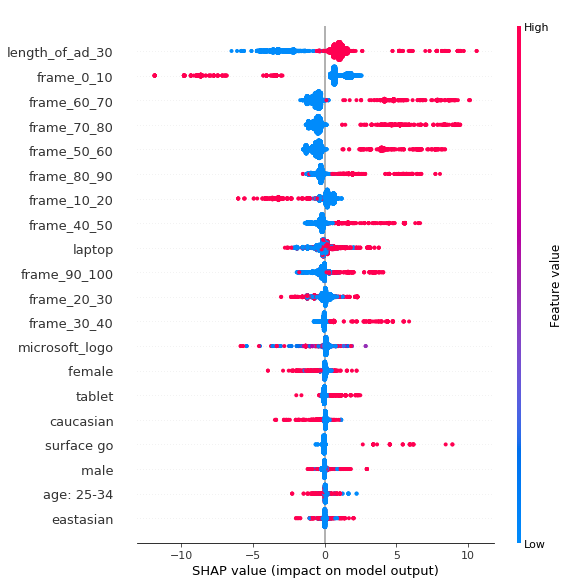

In [28]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values_dt,X_train.drop('Video Name',1),show=False,auto_size_plot=True)
plt.savefig('interest.pdf',bbox_inches = 'tight')

In [36]:
# shap.initjs()
explainer_rf= shap.TreeExplainer(trained_rf[0])
shap_values_rf= explainer_rf.shap_values(X_train.drop('Video Name',1))

In [49]:
explainer_xgb = shap.TreeExplainer(trained_xgb[0])
shap_values_xgb= explainer_xgb.shap_values(X_train.drop('Video Name',1))

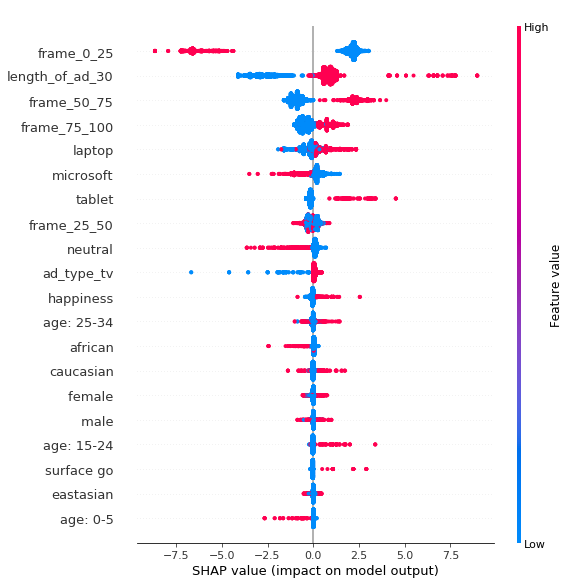

In [48]:
shap.summary_plot(shap_values_rf,X_train.drop('Video Name',1))

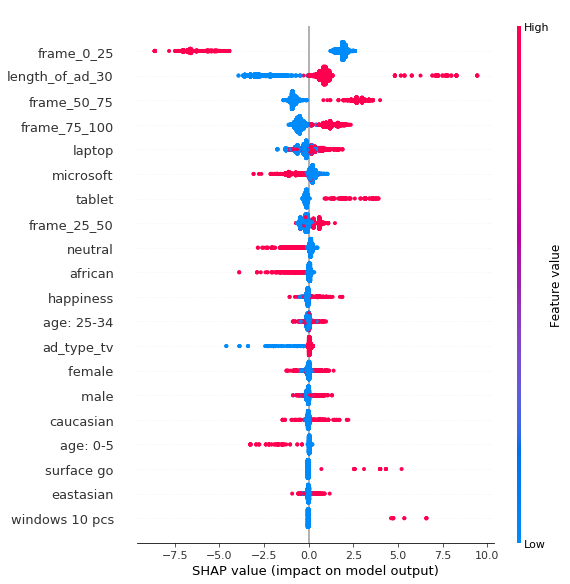

In [50]:
shap.summary_plot(shap_values_xgb,X_train.drop('Video Name',1))

In [61]:
indices = np.argsort(lr.coef_)

In [57]:
X_train.drop('Video Name',1).columns[indices]

Index(['neutral', 'disgust', 'angry', 'happiness', 'sadness', 'fear',
       'surprise', ' male', ' female', 'asus t102', 'dell xps 13', 'lenovo',
       'surface pro 4, apple_macbookair13', 'windows 10, windows',
       'suface laptop', 'intel', 'hp', 'surface pro 4, surface book',
       'surface pro 4, macbook air13, macbook air', 'microsoft',
       'hp spectre x360, windows', 'surface pen', 'the surface laptop',
       'surface laptop', 'laptop', 'windows 10', 'surface pro', 'macbook air',
       'macbook pro', 'hp spectre x360', 'surface pro 4', 'windows',
       'ad_type_tv', 'yoga', 'tablet', 'pc', 'surface pro 4, hp spectre x360',
       'surface book', 'surface pro 4, macbook air', 'length_of_ad_30',
       'windows 10 pc', 'microsoft surface', 'mobile', 'the new surface pro',
       'dell pcs', 'lenovo yoga 720', 'surface pro 4, windows 10',
       'surface go', 'windows 10, hp_spectre', 'windows 10 pcs',
       'surface pro 6', 'dell xps', 'lenovo yoga 910', 'dell', 'asus',

# NN

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import backend as K
from keras.regularizers import l2

Using TensorFlow backend.


In [33]:
def model_nn():
    model = Sequential()
    model.add(Dense(512,input_shape=(75,),activation='relu',kernel_initializer='normal'))
    model.add(Dense(256,activation='relu',kernel_initializer='normal'))
    model.add(Dense(256,activation='relu',kernel_initializer='normal'))
    
#     model.add(Dropout(0.4))
    model.add(Dense(128,activation='relu',kernel_initializer='normal'))
    model.add(Dense(128,activation='relu',kernel_initializer='normal'))
#     model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,activation='linear',kernel_initializer='normal'))
    
    return model

In [34]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [35]:
model = model_nn()
model.compile(optimizer='adam',loss="mean_squared_error",metrics=[r2_keras])

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               38912     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total para

In [37]:
X_train_nn,X_test_nn,y_train_nn,y_test_nn = train_test_split(X_new,Y,test_size=0.3,random_state=123)

In [39]:
history = model.fit(X_train_nn.drop('Video Name',1).values,y_train_nn.values,epochs=20,verbose=1,validation_data=(X_test_nn.drop('Video Name',1).values,y_test_nn.values))

Train on 3731 samples, validate on 1600 samples
Epoch 1/20
3731/3731 [==============================] - 0s 129us/step - loss: 17.3161 - r2_keras: 0.6794 - val_loss: 18.0999 - val_r2_keras: 0.6743
Epoch 2/20
3731/3731 [==============================] - 0s 126us/step - loss: 15.9884 - r2_keras: 0.7041 - val_loss: 19.0779 - val_r2_keras: 0.6499
Epoch 3/20
3731/3731 [==============================] - 0s 129us/step - loss: 16.0484 - r2_keras: 0.7026 - val_loss: 18.5085 - val_r2_keras: 0.6642
Epoch 4/20
3731/3731 [==============================] - 0s 127us/step - loss: 15.9213 - r2_keras: 0.6998 - val_loss: 17.8514 - val_r2_keras: 0.6750
Epoch 5/20
3731/3731 [==============================] - 0s 129us/step - loss: 15.8360 - r2_keras: 0.7106 - val_loss: 17.7426 - val_r2_keras: 0.6777
Epoch 6/20
3731/3731 [==============================] - 0s 129us/step - loss: 15.8728 - r2_keras: 0.7022 - val_loss: 17.9568 - val_r2_keras: 0.6759
Epoch 7/20
3731/3731 [==============================] - 0s 132us

In [159]:
for i,val in enumerate(model.predict(X_test.drop('Video Name',1).values)):
#     print(round(y_test.values[i][0],2),round(val[0],2))
    pass

In [75]:
model.evaluate(X_test.drop('Video Name',1).values,y_test.values)

1600/1600 [==============================] - 0s 33us/step


[21.773721084594726, 0.6038555312156677]

In [41]:
import matplotlib.pyplot as plt

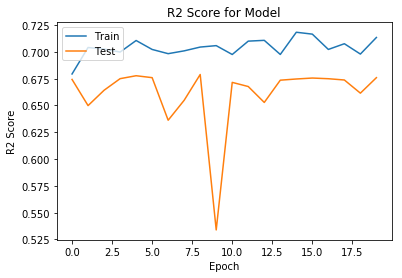

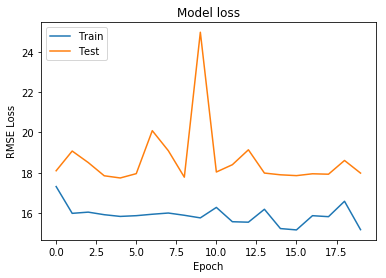

In [42]:
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('R2 Score for Model')
plt.ylabel('R2 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('RMSE Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()